In [1]:
import pandas as pd
import numpy as np
import datetime

%load_ext autoreload

In [21]:
from charts import plot_line
from charts import plot_bar
from features import add_variables_covid
from features import add_variables_apple

%matplotlib inline

In [3]:
def apple_filter_region(df, region):
    df_region = df[df.region == region].T
    df_region.columns = df_region.loc['transportation_type', :]
    df_region = df_region[~df_region.index.isin(['geo_type', 'region', 'transportation_type'])]
    
    df_region['date'] = pd.to_datetime(df_region.index)
    df_region.set_index('date', inplace=True)
    df_region = df_region.astype('float')
    
    return df_region

In [4]:
date_apple = '2020-04-24'
date_now = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%d")

dfapple = pd.read_csv(f"data/AppleMobilty/applemobilitytrends-{date_apple}.csv")

dfcovid_conf = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
dfcovid_dead = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

df_germany = pd.read_csv("data/RKI-reports.csv")

### Add index to RKI data

In [5]:
df_germany['date'] = df_germany['date'].astype('datetime64[ns]')
df_germany = df_germany.sort_values('date', ascending=True)
df_germany.set_index('date', inplace=True)

### Transpose Confirmed Cases

In [50]:
dfcovid_conf_t = dfcovid_conf.T
dfcovid_conf_t.columns = dfcovid_conf_t.loc['Country/Region', :] + "_" + dfcovid_conf_t.loc['Province/State', :].astype(str)

dfcovid_conf_t.drop(['Country/Region'], axis=0, inplace=True)

df_country_coords = dfcovid_conf_t.loc[['Lat', 'Long'], :]

dfcovid_conf_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_conf_t['dates'] = dfcovid_conf_t.index
dfcovid_conf_t['dates'] = dfcovid_conf_t['dates'].astype('datetime64[ns]')
dfcovid_conf_t = dfcovid_conf_t.sort_values('dates', ascending=True)
dfcovid_conf_t.set_index('dates', inplace=True)

### Transpose Dead Cases

In [51]:
dfcovid_dead_t = dfcovid_dead.T
dfcovid_dead_t.columns = dfcovid_dead_t.loc['Country/Region', :] + "_" + dfcovid_dead_t.loc['Province/State', :].astype(str)
dfcovid_dead_t.drop(['Country/Region'], axis=0, inplace=True)


dfcovid_dead_t.drop(['Lat', 'Long', 'Province/State'], axis=0, inplace=True)
dfcovid_dead_t['dates'] = dfcovid_dead_t.index
dfcovid_dead_t['dates'] = dfcovid_dead_t['dates'].astype('datetime64[ns]')
dfcovid_dead_t = dfcovid_dead_t.sort_values('dates', ascending=True)
dfcovid_dead_t.set_index('dates', inplace=True)

In [8]:
# import inspect
# source_DF = inspect.getsource(add_weekday_weekend)
# print(source_DF)


### Transpose Mobility and Filter Region

In [9]:
dfapple_region = apple_filter_region(dfapple, "Hamburg").copy()

### Check max dates in index

In [10]:
print("Mobility max date:", max(dfapple_region.index))
print("Covi world max date", max(dfcovid_conf_t.index))
print("Covi world max date", max(dfcovid_dead_t.index))
print("RKI max date", max(df_germany.index))

Mobility max date: 2020-04-24 00:00:00
Covi world max date 2020-04-25 00:00:00
Covi world max date 2020-04-25 00:00:00
RKI max date 2020-04-25 00:00:00


### Add weekend Column

# Apple Mobility DF

## Create lagged and % variables

In [11]:
dfapple_region = add_variables_apple(dfapple_region)

In [15]:
dfapple_region.tail(3).T

date,2020-04-22,2020-04-23,2020-04-24
transportation_type,,,
driving,71.830000,73.160000,67.720000
transit,60.860000,65.160000,60.880000
walking,66.700000,71.530000,65.290000
transit_avg3,64.000000,63.000000,63.000000
walking_avg3,65.000000,67.000000,69.000000
driving_avg3,71.000000,72.000000,71.000000
transit_l1,65.280000,60.860000,65.160000
walking_l1,64.900000,66.700000,71.530000
driving_l1,70.750000,71.830000,73.160000


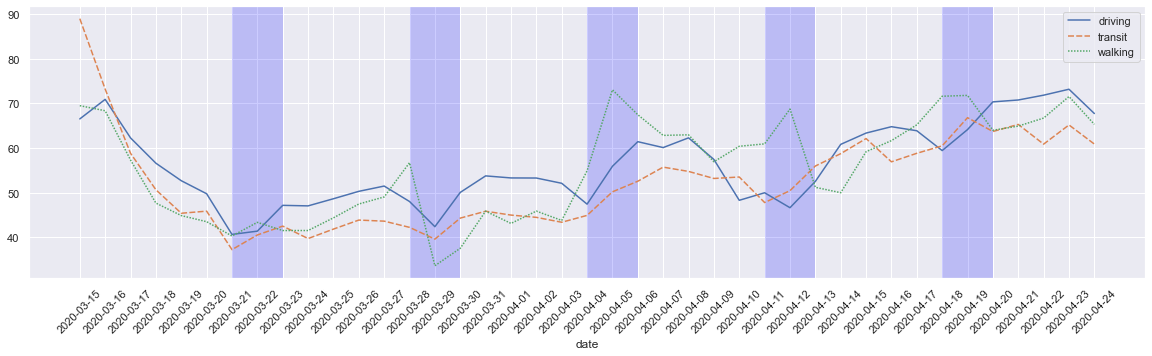

In [11]:
plot_line(dfapple_region, columns=['driving','transit','walking'], date_cutoff='2020-03-15')

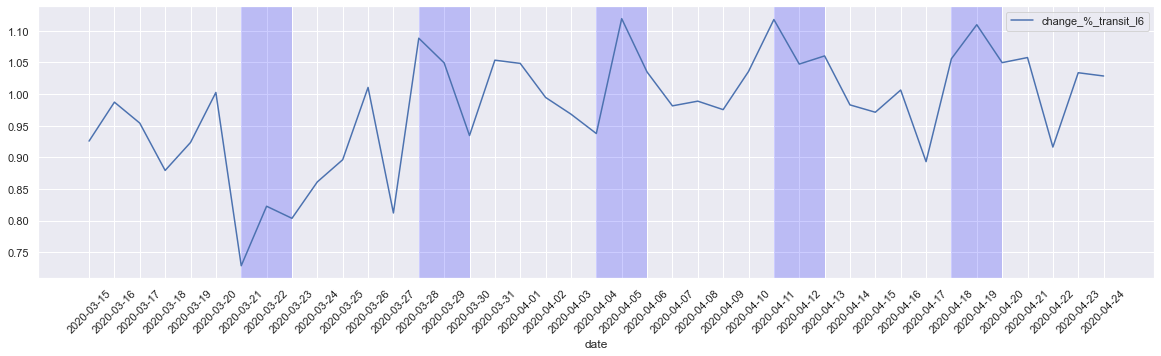

In [17]:
plot_line(dfapple_region, columns=['change_%_transit_l6'], date_cutoff='2020-03-15')

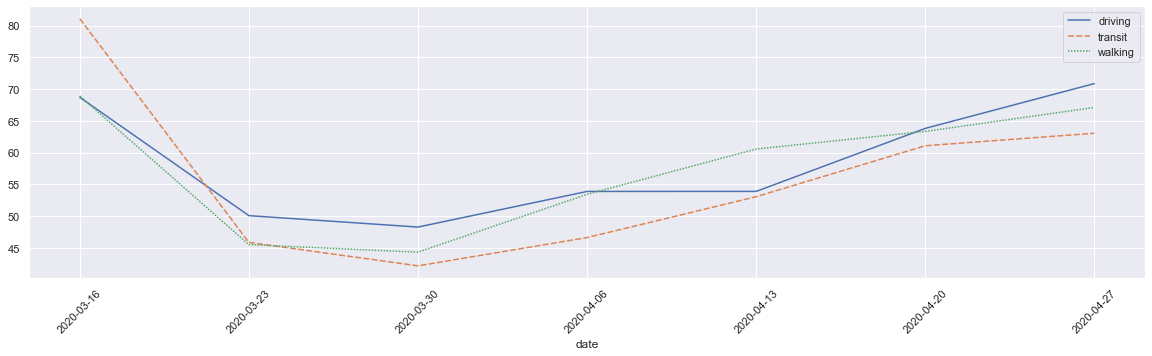

In [12]:
plot_line(dfapple_region, columns=['driving','transit','walking'], resample='W-MON', date_cutoff='2020-03-15')

# Robert Koch Institute DF

## Filter region (Hamburg)

In [18]:
df_hamburg = df_germany.loc[df_germany.land == 'Hamburg', :].copy()
df_hamburg.drop('data', axis=1, inplace=True)

## Create lagged and % variables

In [22]:
df_hamburg = add_variables_covid(df_hamburg, 'confirmed')
# df_hamburg = add_variables(df_hamburg, 'dead')

----

In [23]:
df_hamburg.sort_index(ascending=False).head().T

date,2020-04-25,2020-04-24,2020-04-23,2020-04-22,2020-04-21
land,Hamburg,Hamburg,Hamburg,Hamburg,Hamburg
confirmed,4400,4358,4286,4204,4204
dead,139,122,113,91,91
dow,5,4,3,2,1
weekend,True,False,False,False,False
confirmed_avg3,4350,4284,4224,4199,4185
confirmed_change,42,72,82,0,19
confirmed_change_avg3,67,59,25,14,26
confirmed_change_3w,1703,1762,1880,1893,2013
confirmed_change_pct,0.01,0.017,0.02,0,0.005


# Explore Plots

# Hamburg

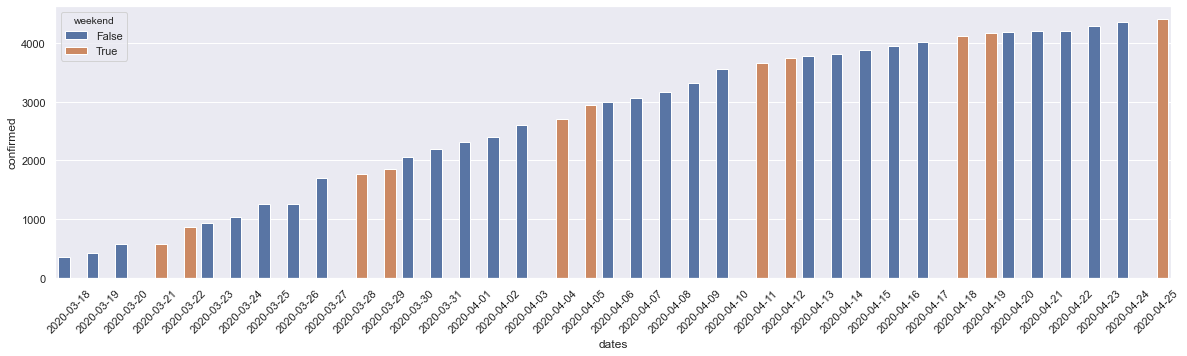

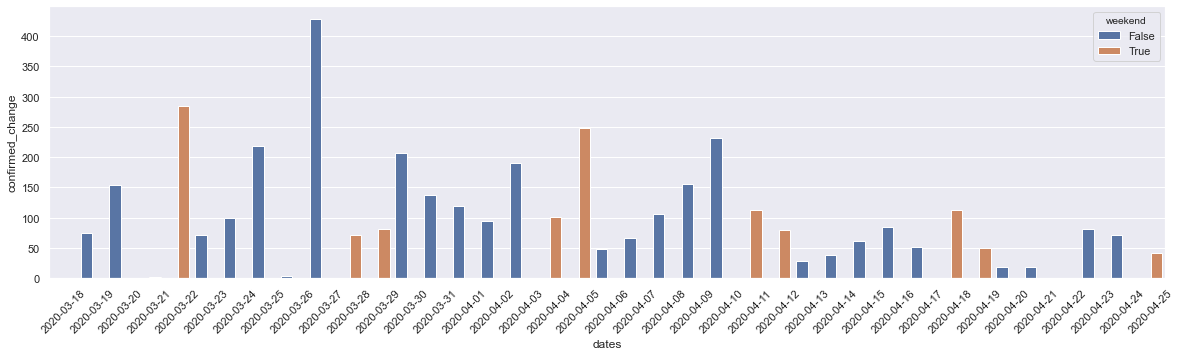

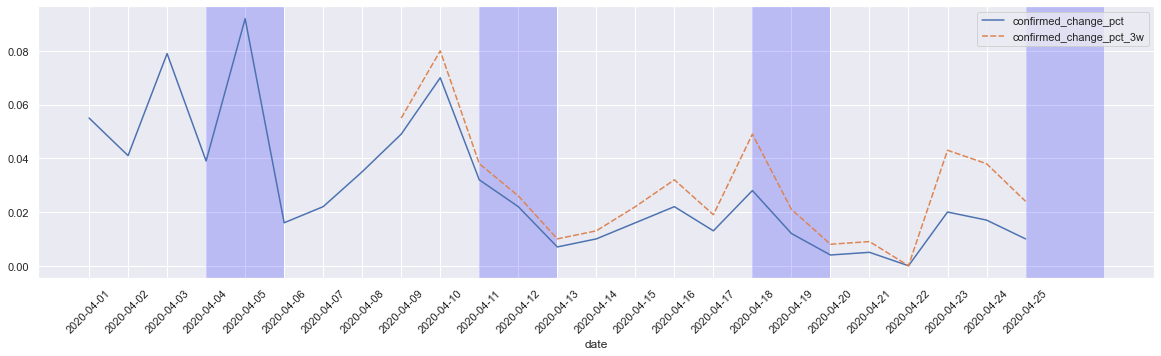

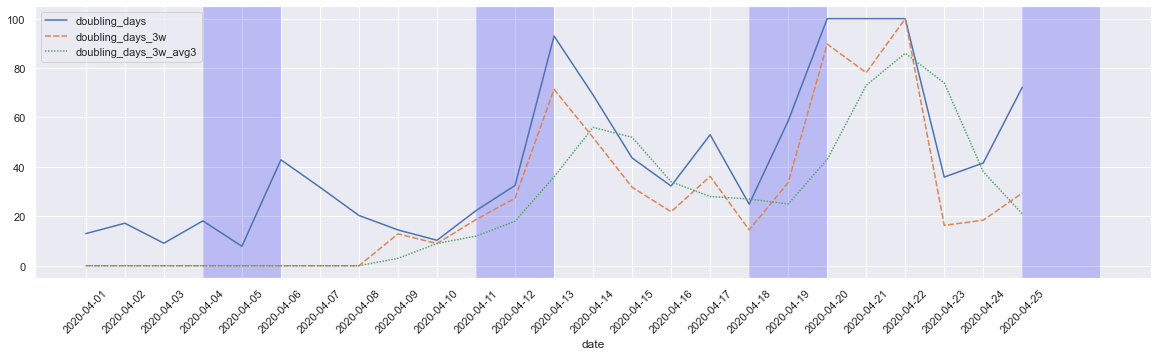

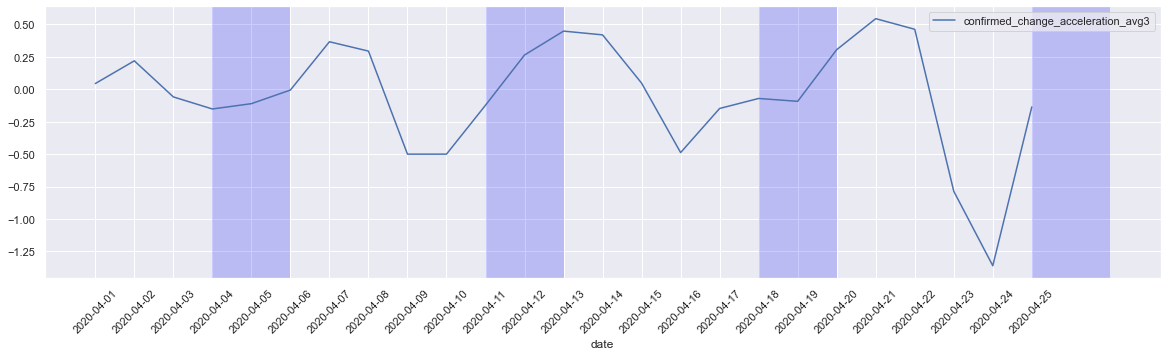

In [45]:
plot_bar(df_hamburg, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_hamburg, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(df_hamburg, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-04-01')
plot_line(df_hamburg, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-04-01')
plot_line(df_hamburg, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-04-01')

---

# Russia

In [52]:
dfcovid_conf_t.head()

,Afghanistan_nan,Albania_nan,Algeria_nan,Andorra_nan,Angola_nan,Antigua and Barbuda_nan,Argentina_nan,Armenia_nan,Australia_Australian Capital Territory,Australia_New South Wales,...,Burundi_nan,Sierra Leone_nan,"Netherlands_Bonaire, Sint Eustatius and Saba",Malawi_nan,United Kingdom_Falkland Islands (Malvinas),France_Saint Pierre and Miquelon,South Sudan_nan,Western Sahara_nan,Sao Tome and Principe_nan,Yemen_nan
dates,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df_russia = dfcovid_conf_t.loc[dfcovid_conf_t.index >= '2020-03-15', ['Russia_nan']]
df_russia.columns = ['confirmed']
df_russia = add_variables_covid(df_russia)

In [58]:
df_russia.head().T

dates,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19
confirmed,63,90,114,147,199
dow,6,0,1,2,3
weekend,True,False,False,False,False
confirmed_avg3,NaN,NaN,89,116,152
confirmed_change,NaN,27,24,33,52
confirmed_change_avg3,NaN,NaN,NaN,27,36
confirmed_change_3w,NaN,NaN,NaN,NaN,NaN
confirmed_change_pct,NaN,0.428571,0.266667,0.289474,0.353741
confirmed_change_pct_avg3,NaN,NaN,NaN,0.303,0.31
confirmed_change_pct_3w,NaN,NaN,NaN,NaN,NaN


DataError: No numeric types to aggregate

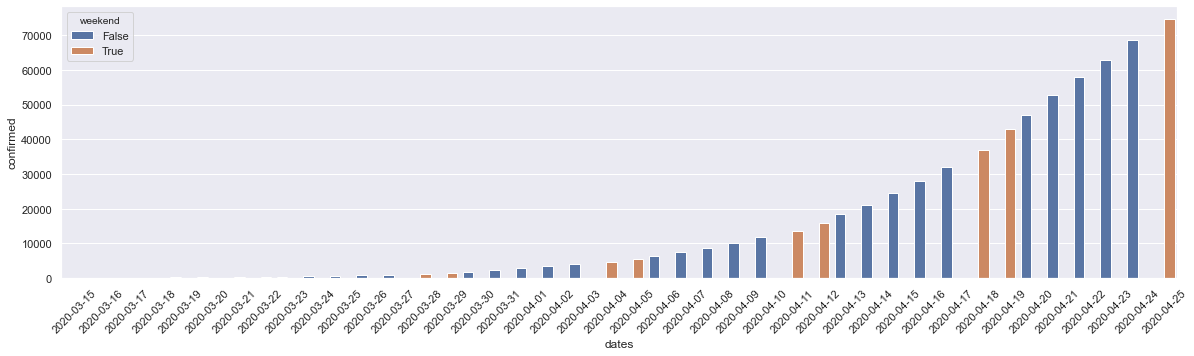

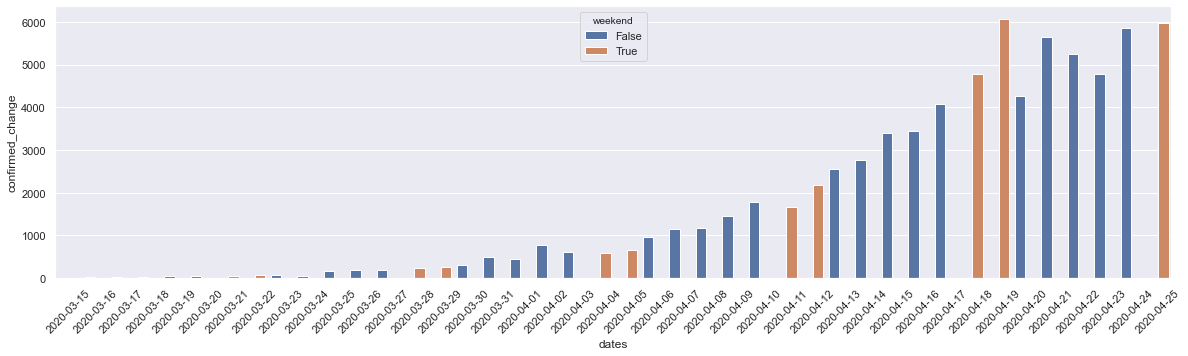

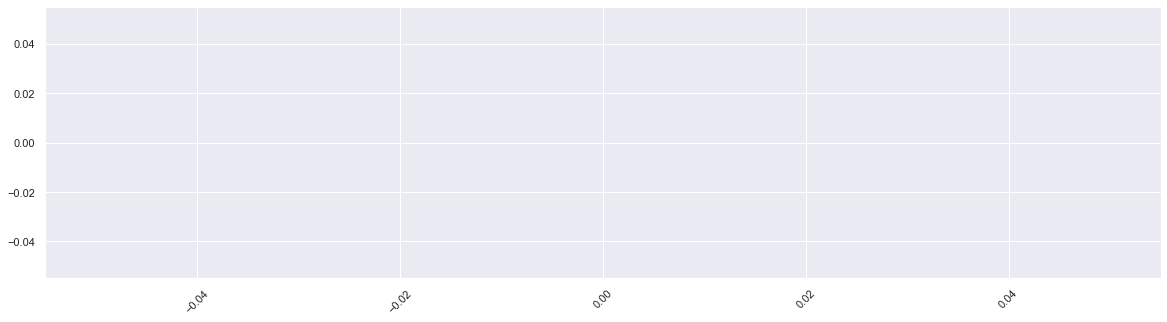

In [56]:
plot_bar(df_russia, columns='confirmed', date_cutoff='2020-03-15')
plot_bar(df_russia, columns='confirmed_change', date_cutoff='2020-03-15')
plot_line(df_russia, columns=['confirmed_change_pct', 'confirmed_change_pct_3w'], date_cutoff='2020-03-01')
plot_line(df_russia, columns=['doubling_days', 'doubling_days_3w', 'doubling_days_3w_avg3'], date_cutoff='2020-03-01')
plot_line(df_russia, columns=['confirmed_change_acceleration_avg3'], date_cutoff='2020-03-01')

## Join RKI and Mobility

In [684]:
df_joined = dfapple_region.join(df_hamburg)

In [685]:
df_joined.loc['2020-03-18':'2020-03-30', ['change_%_conf','change_%_conf_avg3', 'transit', 'walking', 'driving']]

,change_%_conf,change_%_conf_avg3,transit,walking,driving
date,,,,,
2020-03-18,NaN,NaN,50.64,47.66,56.59
2020-03-19,0.21,NaN,45.38,44.86,52.67
2020-03-20,0.36,NaN,45.85,43.49,49.75
2020-03-21,0.00,0.21,37.23,40.28,40.64
2020-03-22,0.49,0.20,40.51,43.34,41.37
2020-03-23,0.08,0.24,42.50,41.51,47.15
2020-03-24,0.11,0.16,39.71,41.51,47.03
2020-03-25,0.21,0.13,41.83,44.35,48.63
2020-03-26,0.00,0.13,43.85,47.45,50.29


In [686]:
dfcovid_conf.loc[dfcovid["Country/Region"] == 'Russia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
187,NaN,Russia,60.0,90.0,0,0,0,0,0,0,...,24490,27938,32008,36793,42853,47121,52763,57999,62773,68622
